# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance
#!pip3 install plotly

## import dependencies

In [98]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
import plotly.graph_objects as go
from binance import Client
from config import API_Key,Secret_Key
import os

## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date_and_Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date_and_Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating historical data : crypto df

In [5]:
lookback = '6 months'
crypto_df= get_crypto_data('BTCUSDT', '30m', lookback).tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(8819, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date_and_Time,,,,,
2021-11-24 04:30:00-06:00,56646.80,56677.84,56408.46,56427.82,811.67715
2021-11-24 05:00:00-06:00,56427.82,56579.56,56311.00,56537.58,598.41087
2021-11-24 05:30:00-06:00,56537.59,56759.45,56500.34,56613.63,571.07870
2021-11-24 06:00:00-06:00,56613.64,56740.78,56400.00,56630.00,795.66886
2021-11-24 06:30:00-06:00,56630.01,56642.73,56398.87,56436.02,689.51641
2021-11-24 07:00:00-06:00,56436.02,56859.48,56277.18,56606.83,1223.07433
2021-11-24 07:30:00-06:00,56606.82,56726.34,56004.59,56025.80,1476.24609
2021-11-24 08:00:00-06:00,56025.80,56350.00,55870.20,56088.52,1691.58298
2021-11-24 08:30:00-06:00,56088.52,56230.66,55837.00,56134.95,1197.01911


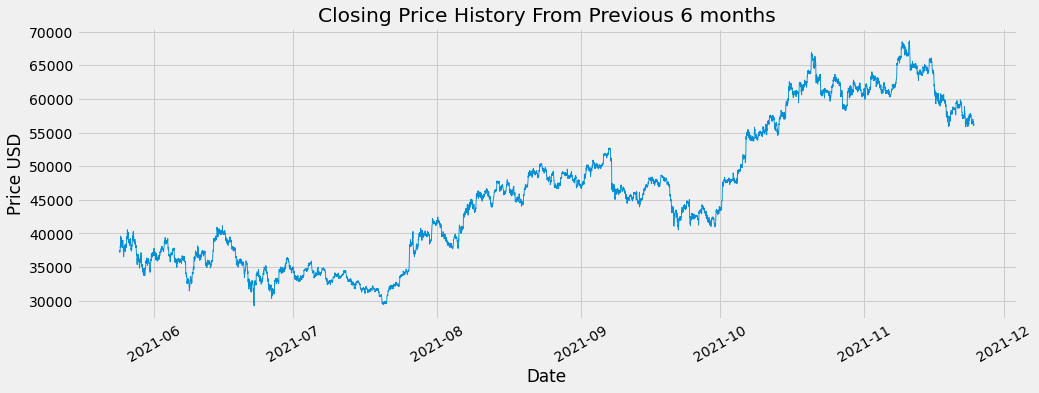

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title(f'Closing Price History From Previous {lookback}')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.xticks(rotation=30)
plt.show()

## historical price w plotly to html

In [116]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')
fig = go.Figure(data=[go.Candlestick(x=crypto_df.index,
                open=crypto_df['Open'],
                high=crypto_df['High'],
                low=crypto_df['Low'],
                close=crypto_df['Last'])])
fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/historical.html')


# code machine larning: Linear regresion and tecnical indicators and forward testing

In [9]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(16)

,Last
Date_and_Time,
2021-05-24 10:30:00-05:00,37539.63
2021-05-24 11:00:00-05:00,37194.32
2021-05-24 11:30:00-05:00,37357.22
2021-05-24 12:00:00-05:00,37652.81
2021-05-24 12:30:00-05:00,37669.77
2021-05-24 13:00:00-05:00,38128.44
2021-05-24 13:30:00-05:00,37911.79
2021-05-24 14:00:00-05:00,38085.39
2021-05-24 14:30:00-05:00,39606.10


In [10]:
#  variable for predicting x number of periods into the future
predict_periods = 16 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-10-91f82b2f9c00>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# show df with new column
crypto_last_price_df.head(16)

,Last,Prediction
Date_and_Time,,
2021-05-24 10:30:00-05:00,37539.63,38796.29
2021-05-24 11:00:00-05:00,37194.32,39447.37
2021-05-24 11:30:00-05:00,37357.22,39387.52
2021-05-24 12:00:00-05:00,37652.81,38999.96
2021-05-24 12:30:00-05:00,37669.77,38808.30
2021-05-24 13:00:00-05:00,38128.44,38298.28
2021-05-24 13:30:00-05:00,37911.79,38083.69
2021-05-24 14:00:00-05:00,38085.39,38242.40
2021-05-24 14:30:00-05:00,39606.10,38304.51


In [12]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(17)

,Last,Prediction
Date_and_Time,,
2021-11-24 01:00:00-06:00,56636.62,56252.15
2021-11-24 01:30:00-06:00,56497.47,NaN
2021-11-24 02:00:00-06:00,56727.22,NaN
2021-11-24 02:30:00-06:00,56849.02,NaN
2021-11-24 03:00:00-06:00,56992.25,NaN
2021-11-24 03:30:00-06:00,56682.55,NaN
2021-11-24 04:00:00-06:00,56646.81,NaN
2021-11-24 04:30:00-06:00,56427.82,NaN
2021-11-24 05:00:00-06:00,56537.58,NaN


In [13]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[37539.63]
 [37194.32]
 [37357.22]
 ...
 [56278.86]
 [56607.  ]
 [56636.62]]


In [14]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[38796.29 39447.37 39387.52 ... 56088.52 56134.95 56252.15]


In [15]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [16]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

## linear regression similarity

In [17]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.8744973453475501


In [18]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[56497.47]
 [56727.22]
 [56849.02]
 [56992.25]
 [56682.55]
 [56646.81]
 [56427.82]
 [56537.58]
 [56613.63]
 [56630.  ]
 [56436.02]
 [56606.83]
 [56025.8 ]
 [56088.52]
 [56134.95]
 [56252.15]]


In [19]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[56505.44425019 56734.58107225 56856.05600121 56998.9037358
 56690.03029166 56654.38567786 56435.98013852 56545.44720093
 56621.29423169 56637.62054193 56444.1582536  56614.51238016
 56035.03308648 56097.58569358 56143.89177692 56260.77898278]


## price results with machine learning prediction

In [20]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual_price', 'predicted_price'])

previously_predicted = results_df[['predicted_price']]

date = datetime.now().strftime("%Y_%m_%d_%I_%M_%S_%p")
previously_predicted.to_csv(f'Resources/previous_predicted_price_{date}.csv') 

pwd = os.getcwd()
path = os.path.join(pwd,'Resources')
entries = os.listdir(path)

price_results_df = pd.concat([results_df, pd.read_csv('Resources/'+ entries[-2])], axis =1)
price_results_df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
price_results_df.columns = ['actual_price', 'predicted_price', 
                                            'previously_predicted_price']
price_results_df = price_results_df.astype(float)
price_results_df.head(17)

,actual_price,predicted_price,previously_predicted_price
0,56497.47,56505.444250,57480.118460
1,56727.22,56734.581072,57188.479219
2,56849.02,56856.056001,56482.337442
3,56992.25,56998.903736,56225.172648
4,56682.55,56690.030292,56035.018748
5,56646.81,56654.385678,56036.227501
6,56427.82,56435.980139,55892.725491
7,56537.58,56545.447201,55891.836407
8,56613.63,56621.294232,56281.734318
9,56630.00,56637.620542,56320.394449


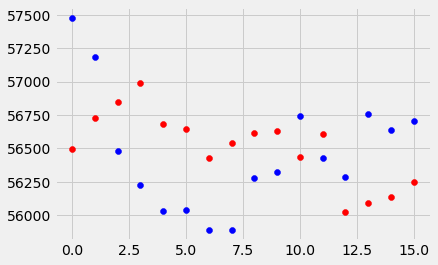

In [21]:
plt.scatter(price_results_df.index,price_results_df.actual_price, color='r', label='actual')
plt.scatter(price_results_df.index, price_results_df.previously_predicted_price, color='b', label='previous')
plt.show()

In [22]:
# for i in range(len(price_results_df)):
#     print(price_results_df.actual_price[i])
correlation = []
for i in range(len(price_results_df)):
    x=(abs(price_results_df.actual_price[i]-\
       price_results_df.previously_predicted_price[i]))/price_results_df.actual_price[i]
    correlation.append(x*100)

In [23]:
similarity_price = pd.DataFrame(correlation)
similarity_price.columns = ['Similarity_percentage']
similarity_price

,Similarity_percentage
0,1.739279
1,0.813118
2,0.645011
3,1.345933
4,1.142382
5,1.077876
6,0.948281
7,1.142149
8,0.586247
9,0.546716


In [24]:
price_results_df.corr()

,actual_price,predicted_price,previously_predicted_price
actual_price,1.000000,1.000000,-0.160865
predicted_price,1.000000,1.000000,-0.160865
previously_predicted_price,-0.160865,-0.160865,1.000000


In [25]:
results_df.describe()

,predicted_price
count,16.000000
mean,56517.231457
std,271.311968
min,56035.033086
25%,56392.179850
50%,56579.979791
75%,56663.296831
max,56998.903736


In [26]:
price_results_df.actual_price.describe()

count       16.000000
mean     56509.288750
std        272.038008
min      56025.800000
25%      56383.902500
50%      56572.205000
75%      56655.745000
max      56992.250000
Name: actual_price, dtype: float64

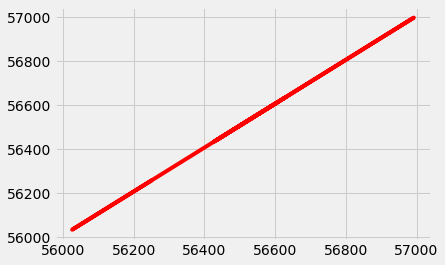

In [27]:
plt.plot(a_projection,Lreg_predict, color='r')

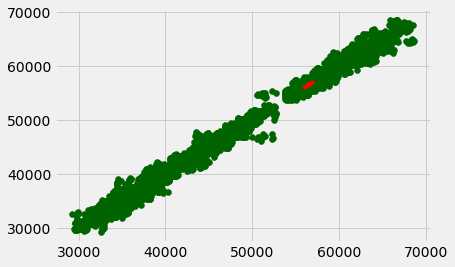

In [28]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## TI MACHINE L GRAPAHS

In [29]:
def TI_MachLearn_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.predicted_price.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.predicted_price.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k')
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r')
    plt.title('MACD graph next 16 periods')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')

   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 2 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['predicted_price'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['predicted_price'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['predicted_price','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['predicted_price'], color = 'k', label='closing price')
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA')
    ax.set_title('BBands next 16 periods')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()    

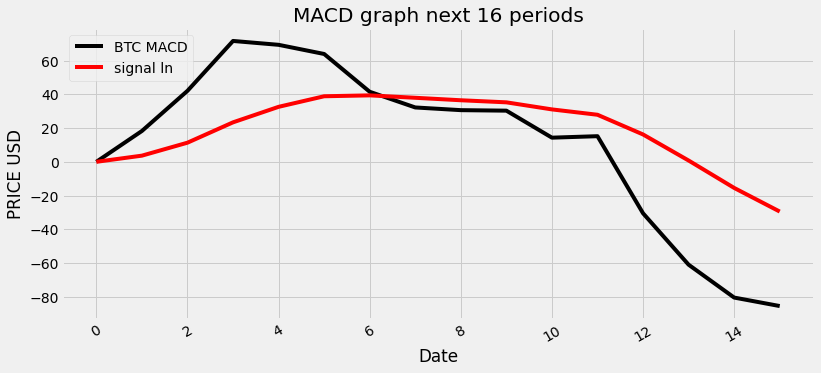

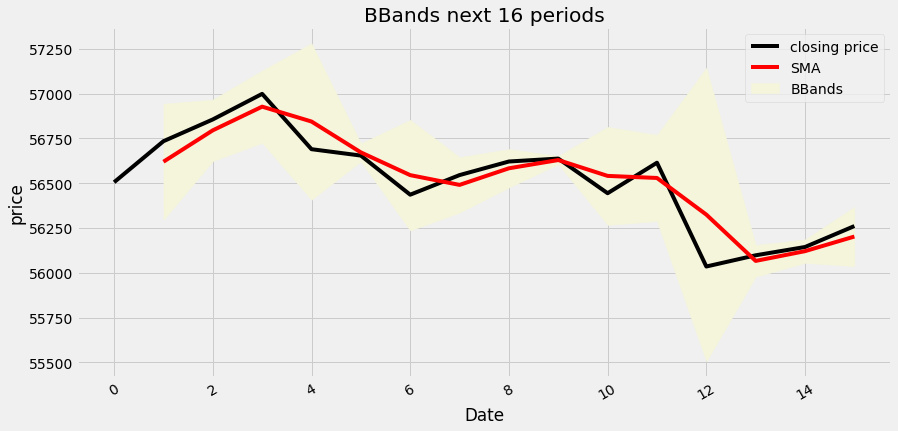

In [30]:
TI_MachLearn_graphs(results_df)

## macd machine learning notification

In [31]:
#buy sell signal
def alert_MACD_ML(signal):
    buy = []
    
    
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            
            if flag != 1:
                buy.append('1')
                
                flag = 1
            else:
                buy.append(np.nan)
                
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)

            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
                
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            
    return(buy, sell)
            

In [32]:
#Create DF for MACD
crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

,actual_price,predicted_price,S_EMA,L_EMA,MACD_line,Sig_line
0,[56497.47],56505.444250,56505.444250,56505.444250,0.000000,0.000000
1,[56727.22],56734.581072,56540.696069,56522.417348,18.278721,3.655744
2,[56849.02],56856.056001,56589.212982,56547.131322,42.081659,11.340927
3,[56992.25],56998.903736,56652.242328,56580.595946,71.646383,23.402018
4,[56682.55],56690.030292,56658.055861,56588.702193,69.353668,32.592348
5,[56646.81],56654.385678,56657.491218,56593.567637,63.923581,38.858595
6,[56427.82],56435.980139,56623.412590,56581.894489,41.518101,39.390496
7,[56537.58],56545.447201,56611.417915,56579.194690,32.223225,37.957042
8,[56613.63],56621.294232,56612.937348,56582.313174,30.624174,36.490468
9,[56630.0],56637.620542,56616.734763,56586.410016,30.324746,35.257324


In [48]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['ML_MACD_Buy_Notification'] = x[0]
crypto_MACD_ML_df['ML_MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['ML_MACD_Buy_Notification',
                                                   'ML_MACD_Sell_Notification']]
crypto_MACD_ML_BuySell_Sig_df.fillna(0)

,ML_MACD_Buy_Notification,ML_MACD_Sell_Notification
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,1
8,0,0
9,0,0


## BBand ML notification

In [34]:
crypto_ML_BBand_df = results_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 2

# calculate SMA
crypto_ML_BBand_df['SMA']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).mean()
#calculate std
crypto_ML_BBand_df['STD']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).std()
#calculate BB UP
crypto_ML_BBand_df['BBand Upper']=crypto_ML_BBand_df['SMA']+(crypto_ML_BBand_df['STD']*2)
#calculate BB LOW
crypto_ML_BBand_df['BBand Lower']=crypto_ML_BBand_df['SMA']-(crypto_ML_BBand_df['STD']*2)

crypto_ML_BBand_df.head()

,actual_price,predicted_price,SMA,STD,BBand Upper,BBand Lower
0,[56497.47],56505.444250,NaN,NaN,NaN,NaN
1,[56727.22],56734.581072,56620.012661,162.024201,56944.061063,56295.964260
2,[56849.02],56856.056001,56795.318537,85.895746,56967.110029,56623.527045
3,[56992.25],56998.903736,56927.479869,101.008602,57129.497072,56725.462665
4,[56682.55],56690.030292,56844.467014,218.406507,57281.280027,56407.654000


In [35]:
#buy sell signal
def alert_ML_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['predicted_price'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['predicted_price'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [47]:
#create buy and sell columns in df
x=alert_ML_BBands(crypto_ML_BBand_df)
crypto_ML_BBand_df['ML_BB_Buy_Notification'] = x[0]
crypto_ML_BBand_df['ML_BB_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_ML_BBand_BuySell_Sig_df = crypto_ML_BBand_df[['ML_BB_Buy_Notification',
                                                     'ML_BB_Sell_Notification']]
crypto_ML_BBand_BuySell_Sig_df.fillna(0)

,ML_BB_Buy_Notification,ML_BB_Sell_Notification
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# Techincal indicators strategy

## MACD df

In [37]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


,Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
Date_and_Time,,,,,,,,,
2021-11-23 23:30:00-06:00,56659.22,56731.24,56500.61,56596.36,520.32932,56761.236235,56942.354317,-181.118082,-98.454586
2021-11-24 00:00:00-06:00,56596.36,56652.76,56214.85,56278.86,760.11171,56687.024507,56893.206590,-206.182083,-120.000085
2021-11-24 00:30:00-06:00,56278.86,56797.02,56270.12,56607.00,745.21399,56674.713044,56872.006102,-197.293058,-135.458680
2021-11-24 01:00:00-06:00,56607.00,56702.47,56427.80,56636.62,578.15812,56668.852576,56854.570095,-185.717519,-145.510448
2021-11-24 01:30:00-06:00,56636.63,56636.63,56389.00,56497.47,660.38657,56642.486026,56828.118236,-185.632210,-153.534800
2021-11-24 02:00:00-06:00,56497.46,56740.97,56389.00,56727.22,650.27847,56655.522022,56820.644292,-165.122270,-155.852294
2021-11-24 02:30:00-06:00,56727.21,57560.00,56632.43,56849.02,1932.51531,56685.290942,56822.746197,-137.455255,-152.172886
2021-11-24 03:00:00-06:00,56849.01,56996.47,56732.35,56992.25,696.14595,56732.515412,56835.302034,-102.786622,-142.295633
2021-11-24 03:30:00-06:00,56992.24,56992.25,56649.93,56682.55,618.68404,56724.828426,56823.987068,-99.158643,-133.668235


## MACD graph w Plotly to html

In [117]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')

fig = go.Figure()
fig.add_trace(go.Scatter(x=crypto_MACD_df.index, y=crypto_MACD_df['MACD_line'],
                        line=dict(color='blue',width = 1.5), name = 'MACD LN'))
fig.add_trace(go.Scatter(x=crypto_MACD_df.index, y=crypto_MACD_df['Sig_line'],
                        line=dict(color='red',width = 1.5), name = 'SIG LN'))


fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/MACD.html')

## MACD buy and sell notification

In [39]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [40]:
#create buy and sell columns in df
x = alert_MACD(crypto_MACD_df)
crypto_MACD_df['MACD_Buy_Notification'] = x[0]
crypto_MACD_df['MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['MACD_Buy_Notification', 'MACD_Sell_Notification']][-16:]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False)

,MACD_Buy_Notification,MACD_Sell_Notification
Date_and_Time,,
2021-11-24 09:00:00-06:00,0,0
2021-11-24 08:30:00-06:00,0,0
2021-11-24 08:00:00-06:00,0,0
2021-11-24 07:30:00-06:00,0,1
2021-11-24 07:00:00-06:00,0,0
2021-11-24 06:30:00-06:00,0,0
2021-11-24 06:00:00-06:00,0,0
2021-11-24 05:30:00-06:00,0,0
2021-11-24 05:00:00-06:00,0,0


## BOLLINGER BANDS df

In [127]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.sort_index(ascending = False).head(32)

,Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
Date_and_Time,,,,,,,,,
2021-11-24 09:00:00-06:00,56134.95,56480.00,56072.66,56252.15,491.99408,56513.3730,250.911611,57015.196222,56011.549778
2021-11-24 08:30:00-06:00,56088.52,56230.66,55837.00,56134.95,1197.01911,56533.8785,245.131164,57024.140828,56043.616172
2021-11-24 08:00:00-06:00,56025.80,56350.00,55870.20,56088.52,1691.58298,56555.1320,226.437126,57008.006252,56102.257748
2021-11-24 07:30:00-06:00,56606.82,56726.34,56004.59,56025.80,1476.24609,56581.2735,198.145058,56977.563615,56184.983385
2021-11-24 07:00:00-06:00,56436.02,56859.48,56277.18,56606.83,1223.07433,56599.9830,156.151041,56912.285082,56287.680918
2021-11-24 06:30:00-06:00,56630.01,56642.73,56398.87,56436.02,689.51641,56591.0715,160.757542,56912.586584,56269.556416
2021-11-24 06:00:00-06:00,56613.64,56740.78,56400.00,56630.00,795.66886,56582.2100,174.086528,56930.383055,56234.036945
2021-11-24 05:30:00-06:00,56537.59,56759.45,56500.34,56613.63,571.07870,56571.8920,177.192670,56926.277339,56217.506661
2021-11-24 05:00:00-06:00,56427.82,56579.56,56311.00,56537.58,598.41087,56593.1475,205.671771,57004.491042,56181.803958


## BBands graphs w plotly to html

In [118]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')

fig = go.Figure()
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['BBand Upper'],
                        line=dict(color='blue',width = 1.5), name = 'BBand Lower'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['BBand Lower'],
                        line=dict(color='blue',width = 1.5), name = 'BBand Lower'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['SMA'],
                        line=dict(color='black',width = 1.5), name = 'SMA'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['Last'],
                        line=dict(color='red',width = 1.5), name = 'Last'))

fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/BBands.html')

## BBand buy sell Notification

In [119]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [125]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['BB_Buy_Notification'] = x[0]
crypto_BBand_df['BB_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['BB_Buy_Notification', 'BB_Sell_Notification']][-16:]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False)

,BB_Buy_Notification,BB_Sell_Notification
Date_and_Time,,
2021-11-24 09:00:00-06:00,0,0
2021-11-24 08:30:00-06:00,0,0
2021-11-24 08:00:00-06:00,0,0
2021-11-24 07:30:00-06:00,0,0
2021-11-24 07:00:00-06:00,0,0
2021-11-24 06:30:00-06:00,0,0
2021-11-24 06:00:00-06:00,0,0
2021-11-24 05:30:00-06:00,0,0
2021-11-24 05:00:00-06:00,0,0


## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [121]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['BB_Buy_Notification'][i] == df2['MACD_Buy_Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['BB_Sell_Notification'][i]== df2['MACD_Sell_Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [122]:
#create buy and sell columns in df
m=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy_Notification'] = m[0]
crypto_alert_df['Sell_Notification'] = m[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy_Notification', 'Sell_Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(17)

,Buy_Notification,Sell_Notification
Date_and_Time,,
2021-11-24 09:00:00-06:00,0,0
2021-11-24 08:30:00-06:00,0,0
2021-11-24 08:00:00-06:00,0,0
2021-11-24 07:30:00-06:00,0,0
2021-11-24 07:00:00-06:00,0,0
2021-11-24 06:30:00-06:00,0,0
2021-11-24 06:00:00-06:00,0,0
2021-11-24 05:30:00-06:00,0,0
2021-11-24 05:00:00-06:00,0,0


In [61]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy_Notification'] == 1]
crypto_buy_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [62]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell_Notification'] == 1]
crypto_sell_df

,Buy_Notification,Sell_Notification
Date_and_Time,,


In [63]:
crypto_df['Last'].describe()

count     8819.000000
mean     45916.824267
std      10504.147491
min      29238.990000
25%      36314.245000
50%      45228.400000
75%      54918.245000
max      68633.690000
Name: Last, dtype: float64

## Technical Indicators graphs

In [99]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title(f'MACD graph from previous {lookback}')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous 8 hours')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    
    
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title(f'BBands previous {lookback}')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour, now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last 8 hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

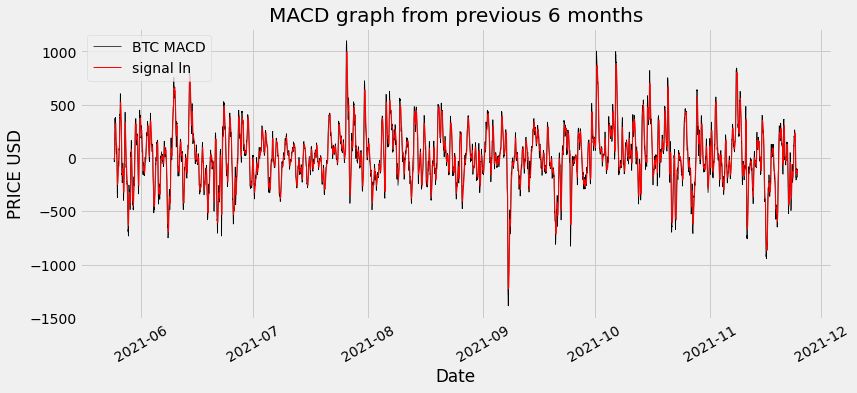

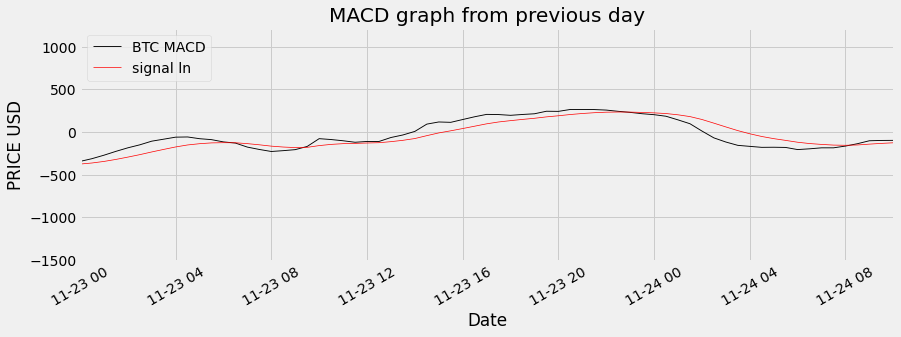

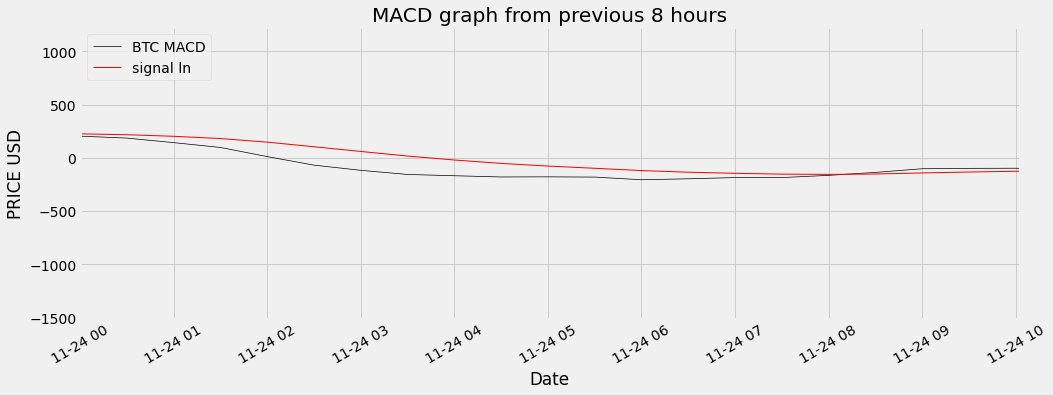

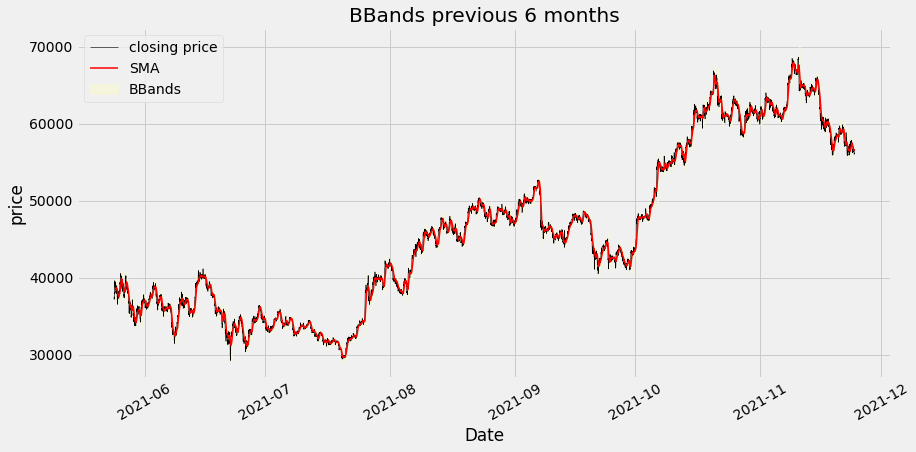

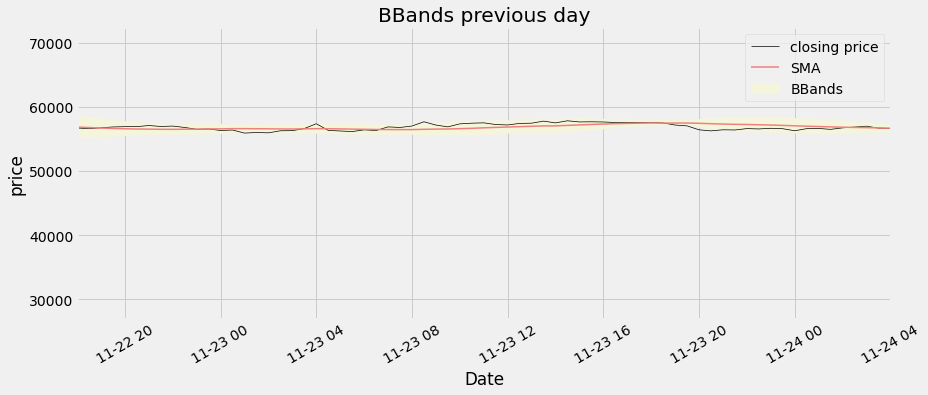

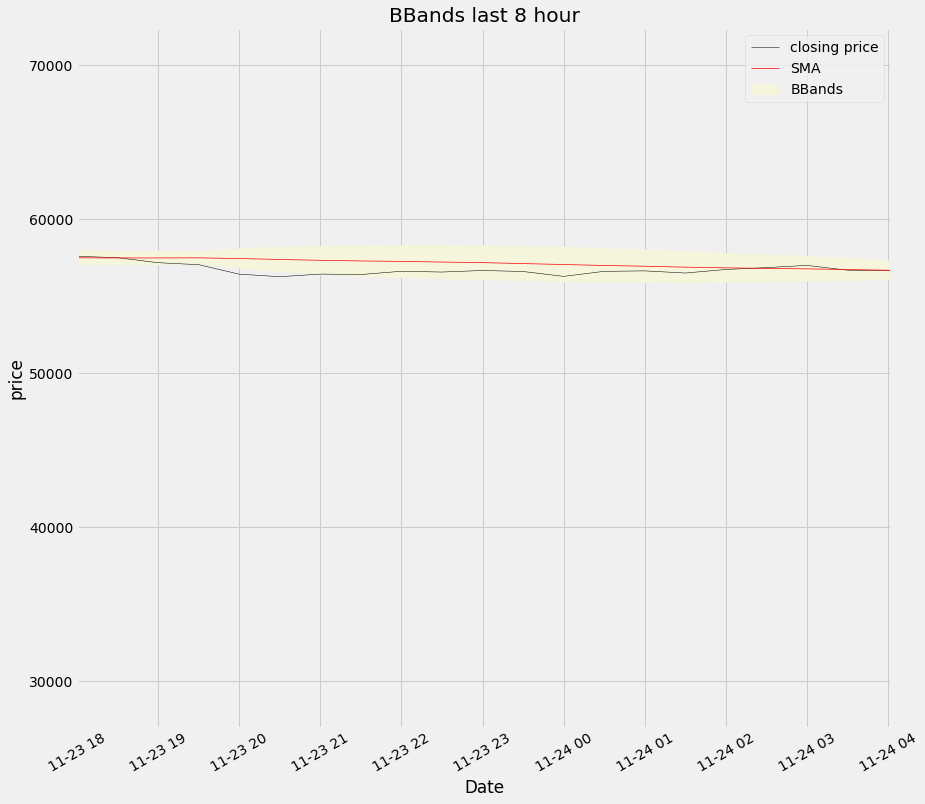

In [129]:
TI_graphs(crypto_df)

## BACKTESTING MACD

In [ ]:
# You cannot asume you will buy or sell exactly on the notification time, 
#but you can assume you will buy in the next time
Buy, Sell = [],[]
for i in range(2,len(crypto_MACD_df)):
    if crypto_MACD_df.MACD_line.iloc[i] > crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]< crypto_MACD_df.Sig_line.iloc[i-1]:
        Buy.append(i)
    elif crypto_MACD_df.MACD_line.iloc[i] < crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]> crypto_MACD_df.Sig_line.iloc[i-1]:
        Sell.append(i)

In [ ]:
realbuy = [i+1 for i in Buy]
realsell = [i+1 for i in Sell]
                                                                             

In [ ]:
buyprice = crypto_MACD_df.Open.iloc[realbuy]
buyprice


In [ ]:
sellprice =crypto_MACD_df.Open.iloc[realsell]
sellprice

In [ ]:
# to calculate profit, exclude initial and final buying or selling condition
if sellprice.index[0]<buyprice.index[0]:
    sellprice = sellprice.drop(sellprice.index[0])
elif buyprice.index[-1]>buyprice.index[-1]:
    buyprice = buyprice.drop(buyprice.index[-1])
    

In [ ]:
profitsrel = []
for i in range(len(sellprice)):
    profitsrel.append((sellprice[i]-buyprice[i])/buyprice[i])

In [ ]:
profits_df = pd.DataFrame(profitsrel)
profits_df.describe()


# recomendation after machine L and TI

In [88]:

df1=crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False)
df2=crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False)
recomendation_df1 = pd.concat([df1, df2], axis =1)
recomendation_df1=recomendation_df1.astype(float)
recomendation_df1

,MACD_Buy_Notification,MACD_Sell_Notification,BB_Buy_Notification,BB_Sell_Notification
Date_and_Time,,,,
2021-11-24 09:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 08:30:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 08:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 07:30:00-06:00,0.0,1.0,0.0,0.0
2021-11-24 07:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 06:30:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 06:00:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 05:30:00-06:00,0.0,0.0,0.0,0.0
2021-11-24 05:00:00-06:00,0.0,0.0,0.0,0.0


In [94]:
df3=crypto_ML_BBand_BuySell_Sig_df.fillna(0)
df4=crypto_MACD_ML_BuySell_Sig_df.fillna(0)
df5 = price_results_df[['actual_price','previously_predicted_price']]
recomendation_df2 = pd.concat([df4,df3,df5, similarity_price], axis =1)
recomendation_df2

,ML_MACD_Buy_Notification,ML_MACD_Sell_Notification,ML_BB_Buy_Notification,ML_BB_Sell_Notification,actual_price,previously_predicted_price,Similarity_percentage
0,0,0,0.0,0.0,56497.47,57480.118460,1.739279
1,1,0,0.0,0.0,56727.22,57188.479219,0.813118
2,0,0,0.0,0.0,56849.02,56482.337442,0.645011
3,0,0,0.0,0.0,56992.25,56225.172648,1.345933
4,0,0,0.0,0.0,56682.55,56035.018748,1.142382
5,0,0,0.0,0.0,56646.81,56036.227501,1.077876
6,0,0,0.0,0.0,56427.82,55892.725491,0.948281
7,0,1,0.0,0.0,56537.58,55891.836407,1.142149
8,0,0,0.0,0.0,56613.63,56281.734318,0.586247
9,0,0,0.0,0.0,56630.00,56320.394449,0.546716
